# 10. Machine Learning Model and Evaluation

#### This script trains a baseline and 'main' model on the training data and evaluates them on the test set

### Imports

In [1]:
import pandas as pd
import sklearn
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from scipy.stats import reciprocal, uniform
from joblib import dump, load
import seaborn as sns
import matplotlib.pyplot as plt

### Definitions

In [2]:
data_filename = 'data/MachineLearningData.csv'

baseline_model_filename = 'TrainedModels/Baseline.bin'
final_model_filename = 'TrainedModels/Final.bin'

svm_model_filename = 'TrainedModels/SVM.bin'

### Defining helper function

In [3]:
def plot_confusion_matrix(targets = [], predicted = [], labels = []):
    cm = metrics.confusion_matrix(targets, predicted)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize confusion matrix
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.rcParams["figure.figsize"] =  [15, 9]
    plt.show(block=False)

### Load Dataframe

In [4]:
# Note: We call this df_train for memory issues
df_train = pd.read_csv(data_filename).dropna()
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train

,PostID,WordCount,SentenceCount,AvgWordLength,AvgSentenceLength,UniqueWordsPercentage,URLCount,ableWords,alWords,fulWords,...,fw_by,fw_these,fw_second,fw_do,fw_shall,fw_of,fw_most,fw_mine,fw_under,fw_even
0,81689.0,95,4,3.578947,23.750000,0.673684,0.000000,0.000000,0.010526,0.000000,...,0.000000,0.0,0.0,0.009804,0.0,0.000000,0.0,0.0,0.0,0.0
1,44109.0,232,20,4.047414,11.600000,0.599138,0.000000,0.000000,0.008621,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
2,415514.0,179,11,4.050279,16.272727,0.659218,0.000000,0.000000,0.005587,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.014851,0.0,0.0,0.0,0.0
3,668957.0,246,21,4.174797,11.714286,0.626016,0.000000,0.000000,0.004065,0.012195,...,0.000000,0.0,0.0,0.000000,0.0,0.010563,0.0,0.0,0.0,0.0
4,42325.0,112,5,4.339286,22.400000,0.598214,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.008197,0.0,0.016393,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676308,145149.0,302,15,3.913907,20.133333,0.536424,0.000000,0.003311,0.000000,0.000000,...,0.000000,0.0,0.0,0.003021,0.0,0.012085,0.0,0.0,0.0,0.0
676309,676161.0,57,5,3.684211,11.400000,0.789474,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
676310,286971.0,4,1,3.750000,4.000000,1.000000,0.250000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
676311,664190.0,90,10,4.800000,9.000000,0.800000,0.033333,0.000000,0.000000,0.000000,...,0.016529,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


### Filter and split into train and test set

In [5]:
df_test = df_train[ df_train['TrainTest'] == 'test' ]

# df_male = df_test[ df_test['Gender'] == 'male' ][:5000]
# df_female = df_test[ df_test['Gender'] == 'female' ][:5000]
# df_test = df_male.append(df_female, ignore_index=True)

y_test = df_test['Gender']
df_test = df_test.drop(['TrainTest', 'Gender', 'PostID'], axis=1)

df_train = df_train[ df_train['TrainTest'] == 'train' ]

# df_male = df_train[ df_train['Gender'] == 'male' ][:5000]
# df_female = df_train[ df_train['Gender'] == 'female' ][:5000]
# df_train = df_male.append(df_female, ignore_index=True)

y_train = df_train['Gender']
df_train = df_train.drop(['TrainTest', 'Gender', 'PostID'], axis=1)

### Check how many train and test items there are

In [6]:
print('Number of TOTAL training examples: {0}'.format(df_train.shape[0]))
print('Number of MALE training examples: {0}'.format(np.sum(y_train == 'male' )))
print('Number of FEMALE training examples: {0}'.format(np.sum(y_train == 'female')))
print()
print('Number of TOTAL testing examples: {0}'.format(df_test.shape[0]))
print('Number of MALE testing examples: {0}'.format(np.sum(y_test == 'male')))
print('Number of FEMALE testing examples: {0}'.format(np.sum(y_test == 'female')))

Number of TOTAL training examples: 537215
Number of MALE training examples: 268572
Number of FEMALE training examples: 268643

Number of TOTAL testing examples: 139098
Number of MALE testing examples: 74300
Number of FEMALE testing examples: 64798


### Train the baseline

In [7]:
# Tune hyperparmeters by sklearn's random search
param_distributions =  {"C": uniform(0.001, 10)}

lr = LogisticRegression(penalty='l2', tol=0.0001, C=1.0,
                        fit_intercept=True, class_weight=None,
                        random_state=42, solver='newton-cg', max_iter=100, multi_class='auto',
                        verbose=1, warm_start=False, n_jobs=-1, l1_ratio=None)

# random search trough the hyperparameters
clf_search_cv = RandomizedSearchCV(lr,
                                    param_distributions,
                                    iid=False,
                                    n_iter=20,
                                    n_jobs=2,
                                    pre_dispatch='2*n_jobs',
                                    cv=5,
                                    refit=True,
                                    verbose=False, 
                                    random_state=42,
                                    return_train_score=False
                                   )

clf_search_cv.fit(df_train.iloc[:10000], y_train[:10000])

lr = clf_search_cv.best_estimator_
lr

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.9s finished


LogisticRegression(C=9.50814306409916, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=42, solver='newton-cg', tol=0.0001, verbose=1,
                   warm_start=False)

In [8]:
# Train it
lr.fit(df_train, y_train)
dump(lr, baseline_model_filename)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 32.2min finished


['TrainedModels/Baseline.bin']

### Evaluate the baseline

              precision    recall  f1-score   support

      female       0.58      0.57      0.57     64798
        male       0.63      0.64      0.63     74300

    accuracy                           0.60    139098
   macro avg       0.60      0.60      0.60    139098
weighted avg       0.60      0.60      0.60    139098



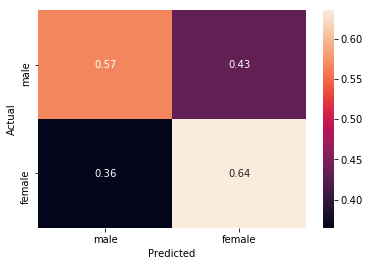

In [9]:
lr = load(baseline_model_filename)
predictions = lr.predict(df_test)
print(metrics.classification_report(y_test, predictions))
plot_confusion_matrix(targets=y_test, predicted=predictions, labels=['male', 'female'])
print(metrics.confusion_matrix(y_test, predictions))

### Train the main model

In [7]:
# Tune hyperparmeters by sklearn's random search
param_distributions =  {'learning_rate_init': uniform(0.0001, 0.1),
                       'alpha': uniform(0.00001, 0.1)}

mlp = MLPClassifier (hidden_layer_sizes=(df_train.shape[1]+100, ),
                     activation='relu',
                     solver='adam', alpha=0.0001, batch_size=10000,
                     learning_rate='constant', learning_rate_init=0.001,
                     max_iter=100, shuffle=True, random_state=42,
                     tol=0.0001, verbose=False, warm_start=False, momentum=0.8,
                     early_stopping=True, validation_fraction=0.2,
                     beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10)
# random search trough the hyperparameters
clf_search_cv = RandomizedSearchCV(mlp,
                                    param_distributions,
                                    iid=False,
                                    n_iter=30,
                                    n_jobs=-1,
                                    pre_dispatch='2*n_jobs',
                                    cv=3,
                                    refit=True,
                                    verbose=True, 
                                    random_state=42,
                                    return_train_score=False
                                   )

clf_search_cv.fit(df_train.iloc[:1000],
                  y_train[:1000])

mlp = clf_search_cv.best_estimator_
mlp

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   56.0s finished
/home/danielcauchi/miniconda3/envs/nlp/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:350: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


MLPClassifier(activation='relu', alpha=0.060121501174320885, batch_size=10000,
              beta_1=0.9, beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(265,), learning_rate='constant',
              learning_rate_init=0.07090725777960455, max_iter=100,
              momentum=0.8, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.2, verbose=False,
              warm_start=False)

In [8]:
# Train it
mlp.max_iter=300
mlp.n_iter_no_change=20
mlp.batch_size=100000
mlp.verbose = True
mlp.fit(df_train, y_train)
dump(mlp, final_model_filename)

Iteration 1, loss = inf
Validation score: 0.499930
Iteration 2, loss = inf
Validation score: 0.500070
Iteration 3, loss = inf
Validation score: 0.499930
Iteration 4, loss = inf
Validation score: 0.499930
Iteration 5, loss = inf
Validation score: 0.516320
Iteration 6, loss = 0.69540682
Validation score: 0.499930
Iteration 7, loss = 0.69510249
Validation score: 0.499921
Iteration 8, loss = inf
Validation score: 0.502322
Iteration 9, loss = 0.69536828
Validation score: 0.503811
Iteration 10, loss = 0.69467637
Validation score: 0.502843
Iteration 11, loss = 0.69496794
Validation score: 0.505542
Iteration 12, loss = 0.69441946
Validation score: 0.506380
Iteration 13, loss = 0.69424014
Validation score: 0.507050
Iteration 14, loss = 0.77037609
Validation score: 0.511136
Iteration 15, loss = inf
Validation score: 0.499940
Iteration 16, loss = 0.69507440
Validation score: 0.499949
Iteration 17, loss = 0.69531557
Validation score: 0.499921
Iteration 18, loss = 0.69484683
Validation score: 0.499

['TrainedModels/Final.bin']

### Evaluate the Final

              precision    recall  f1-score   support

      female       0.53      0.55      0.54     64798
        male       0.60      0.58      0.59     74300

    accuracy                           0.57    139098
   macro avg       0.56      0.57      0.56    139098
weighted avg       0.57      0.57      0.57    139098



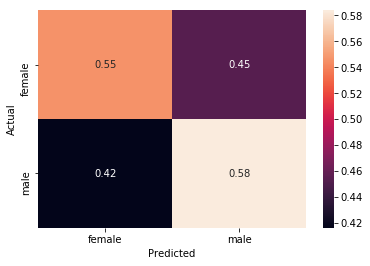

[[35402 29396]
 [30913 43387]]


In [9]:
mlp = load(final_model_filename)
predictions = mlp.predict(df_test)
print(metrics.classification_report(y_test, predictions))
plot_confusion_matrix(targets=y_test, predicted=predictions, labels=np.unique(y_test))
print(metrics.confusion_matrix(y_test, predictions))

### Train another model

In [10]:
# Tune hyperparmeters by sklearn's random search
param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}

svm = SVC('rbf')

# random search trough the hyperparameters
clf_search_cv = RandomizedSearchCV(svm,
                                    param_distributions,
                                    iid=False,
                                    n_iter=30,
                                    n_jobs=-1,
                                    pre_dispatch='2*n_jobs',
                                    cv=3,
                                    refit=True,
                                    verbose=True, 
                                    random_state=42,
                                    return_train_score=False
                                   )

clf_search_cv.fit(df_train.iloc[:1000],
                  y_train[:1000])

svm = clf_search_cv.best_estimator_
svm

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.7min finished


SVC(C=2.560186404424365, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.002051110418843397,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [11]:
# Train it
svm.max_iter=1000
svm.verbose = True
svm.fit(df_train, y_train)
dump(svm, svm_model_filename)

[LibSVM]

/home/danielcauchi/miniconda3/envs/nlp/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


['TrainedModels/SVM.bin']

### Evaluate the Final

              precision    recall  f1-score   support

      female       0.47      0.87      0.61     64798
        male       0.56      0.14      0.23     74300

    accuracy                           0.48    139098
   macro avg       0.52      0.51      0.42    139098
weighted avg       0.52      0.48      0.41    139098



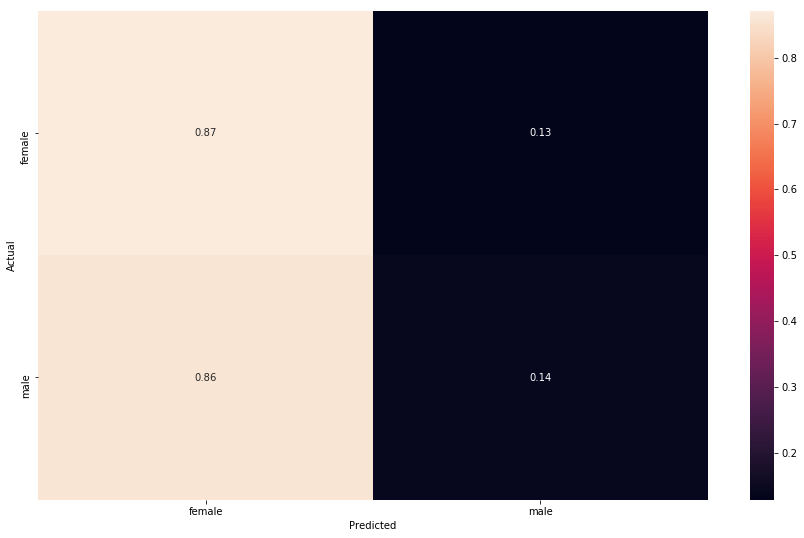

[[56476  8322]
 [63689 10611]]


In [12]:
svm = load(svm_model_filename)
predictions = svm.predict(df_test)
print(metrics.classification_report(y_test, predictions))
plot_confusion_matrix(targets=y_test, predicted=predictions, labels=np.unique(y_test))
print(metrics.confusion_matrix(y_test, predictions))